## Gel analysis for denatured DNA samples 

The DNA samples were denatured with heatshock and formamide after no-treatment and treatment with RNase HII to reveal presence of rNMPs in RNAse H2 wildtype cells and in even higher frequency in RNAse H2 KO cells.

In [16]:
# Process image
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
from PIL import Image
import os
import numpy as np
%matplotlib inline
from gelpy import Gel
import pandas as pd
from numpy.polynomial import polynomial as P
import math
from scipy.optimize import curve_fit

palette = {
    'ladder' : '#FFFFFF' ,#9B9B9B, FFFFFF
    'CD4T' : '#FF7F0E', 
    'hESC-H9' : '#2CA02C', 
    'HEK293T' : '#D62728',
    'RNH2-KO-T3-8' : '#E377C2',
    'RNH2-KO-T3-17' : '#9467BD'
}

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def calc_stats(n_mws, values):
    sm = sum(values)
    curr = 0
    stats={}
    stats['min']=n_mws[0]
    #stats['max']=n_mws[len(n_mws)-1]
    for i, mw in enumerate(n_mws):
        curr += values[i]/sm
        if curr <= 0.5:
            stats['median']=mw
        if curr <= 0.25:
            stats['q1']=mw
        if curr <= 0.75:
            stats['q3']=mw
        if curr <= 0.05:
            stats['min']=mw
        if curr <= 0.95:
            stats['max']=mw
    return stats

#Calculating the Number (N) of nucleotides loaded in 500 ng
w=330*10e9  #weight of DNA bases in 330gms/mole converted to nanograms #given the denaturing conditions, we have single stranded bases even for the ladder. 
M=6.023 * 10e23 #Avogadro's number 
W=250 #weight of DNA(ng) added in the lane
N = W/w * M
print("Number of DNA bases in " + str(W) +"ng of DNA loaded per well :" + str(N))

import math
def calc_mean(n_mws, values):
    num=sum(values*n_mws)
    sm = sum(values)
    mean=num/sm
    return mean

def calc_std(n_mws, values):
    num=sum(values*n_mws)
    sm = sum(values)
    mean=num/sm
    std=math.sqrt((sum(values*n_mws*n_mws)/sm) - (mean*mean))
    return std

def calc_ci(n_mws, values):
    sm = sum(values)
    curr = 0
    stats={}
    stats['min']=n_mws[0]
    return std

q_cutoff=0.05

os.listdir()
img = Image.open("sample cropped gel.jpg").convert('L')

#img = PIL.ImageOps.invert(img)
img.save('gel_grey.png')

Number of DNA bases in 250ng of DNA loaded per well :456287878787878.8


## Using Gelpy to set up gel images and lane pixel ranges.

Please refere to Gelpy instructions for more usage information.

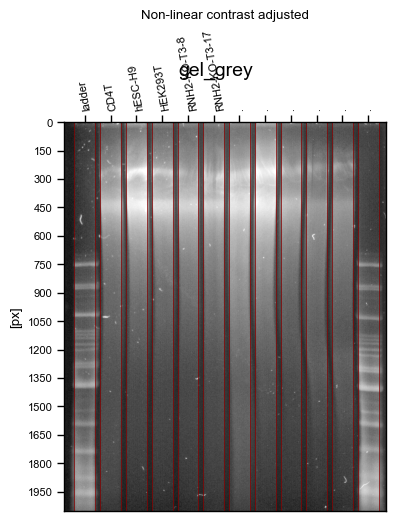

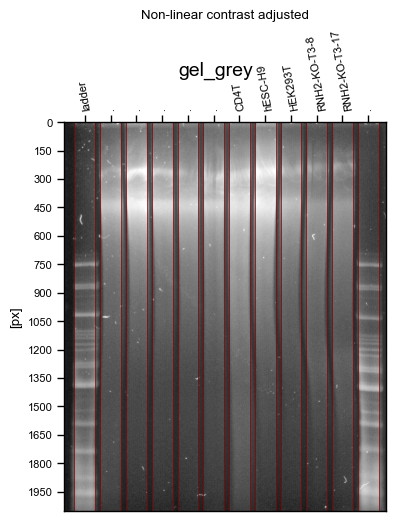

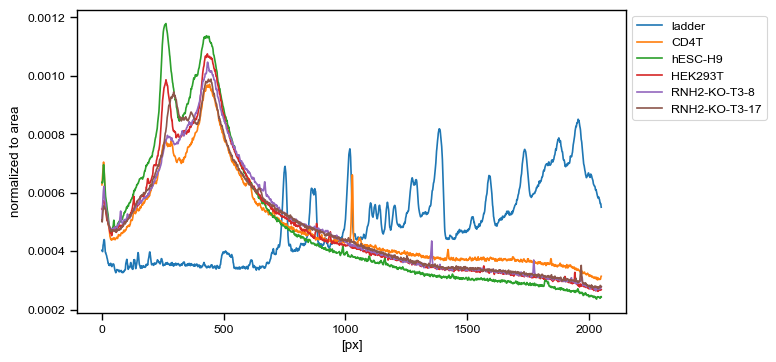

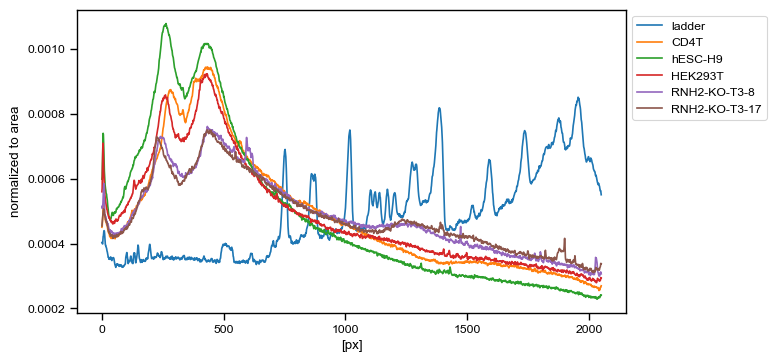

In [17]:
ngel = Gel("gel_grey.png"); agel = Gel("gel_grey.png")
ngel.setup_gel(labels= ['ladder','CD4T', 'hESC-H9', 'HEK293T', 'RNH2-KO-T3-8','RNH2-KO-T3-17','.', '.', '.', '.','.','.'],x_label_pos=(110,1605,12),line_profile_width=110,label_rotation=100,remove_bg=False,img_height_factor=1)
agel.setup_gel(labels= ['ladder','.', '.', '.', '.','.','CD4T', 'hESC-H9', 'HEK293T', 'RNH2-KO-T3-8','RNH2-KO-T3-17','.'],x_label_pos=(110,1605,12),line_profile_width=110,label_rotation=100,remove_bg=False,img_height_factor=1)

ngel.show_line_profiles(select_lanes=[0,1,2,3,4,5], fit=False ,maxima_prominence=0, maxima_threshold=0, plot_fits=False, show_df=False,save_overview=True, show_overview=True)
agel.show_line_profiles(select_lanes=[0,6,7,8,9,10], fit=False ,maxima_prominence=0, maxima_threshold=0, plot_fits=False, show_df=False,save_overview=True, show_overview=True)



### Exponential Curve fitting 
Using ladder known molecular weights and pixel locations estimated using center of the peaks to generate Exponential decay curve estimates.

Using the above fitted cirve estimates to then convert pixel locations to molecular weights for row of pixel in the gel image. 

Fitted exponential decay equation: y = 37918.6449 * exp(-1.8211e-03 * x)+ -1.2934e+02


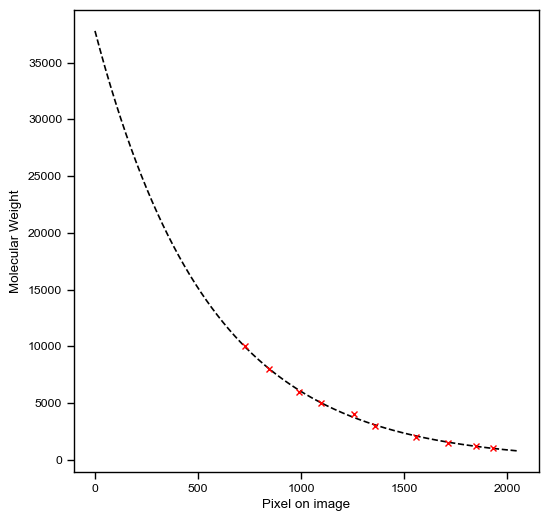

In [18]:
# Getting gel lane data for untreated and treated samples from gelpy matrix

ndata = pd.DataFrame()
for i, lane in enumerate(['ladder','CD4T', 'hESC-H9', 'HEK293T', 'RNH2-KO-T3-8','RNH2-KO-T3-17']):
    ndata[lane] = ngel.LineProfiles.selected_line_profiles_normalized[i] #range in pixels
for k in ndata: 
    ndata[k]=ndata[k]-ndata[k].min()
    ndata[k]=ndata[k]/ndata[k].sum()*100

adata = pd.DataFrame()
for i, lane in enumerate(['ladder','CD4T', 'hESC-H9', 'HEK293T', 'RNH2-KO-T3-8','RNH2-KO-T3-17']):
    adata[lane] = agel.LineProfiles.selected_line_profiles_normalized[i] #range in pixels
for k in adata: 
    adata[k]=adata[k]-adata[k].min()
    adata[k]=adata[k]/adata[k].sum()*100

pixels=len(ndata[lane]) #Indicate the largest molecule allowed
npixels = pixels; apixels = pixels 
np.savetxt('ladder_values.csv',moving_average(ndata['ladder'],50),delimiter=",") #Save the file to confirm pixel locations with highest signal for each marker in ladder. 

# Curved fit (exponential decay) to get fragment length in each pixels
mw = np.array([[1928, 1000],
               [1850, 1200],
               [1713, 1517],
               [1559, 2017],
               [1358, 3001],
               [1256, 4001],
               [1096, 5001],
               [990, 6001],
               [842, 8001],
               [728, 10002]])

X = mw[:,0]; y = mw[:, 1] 
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c
a, b, c = curve_fit(exp_decay, X, y, p0=[200, 0.0001, 5], maxfev=1000)[0]
print(f"Fitted exponential decay equation: y = {a:.4f} * exp(-{b:.4e} * x)+ {c:.4e}")

# Extracting molecular weights for each row represented by pixels in the image
mws = exp_decay(range(max(1000, pixels)), a, b, c)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(range(len(mws)), mws, 'k--')
ax.plot(mw[:,0], mw[:,1], 'rx')
plt.ylabel('Molecular Weight')
plt.xlabel('Pixel on image')
plt.show()
fig.savefig('alkaline_pixels_MW.png')


# Number of fragment estimation for each lane

We get the number of fragments present in each pixelated row in each lane with the assumption that SYBR gold staining intensity represents amount of DNA being stained, and as we move to lower molecular weights, the numer of fragments would be more for the same intensity of high molecular weight fragments. 

In [20]:

#Normalization to get number of fragment in each lane - normalizing for SYBR gold
nnorm_data = {}
ci_list=[]
for k in ndata:
    replace_list=[]
    replace_list=ndata[k]-ndata[k].quantile([q_cutoff]).values
    replace_list=replace_list.clip(lower=0)
    #replace_list=replace_list/replace_list.sum()*100
    ci_list.append((replace_list - replace_list.quantile(q_cutoff)).abs().idxmin())
    nnorm_data[k] = []
    for i, v in enumerate(replace_list):
        nnorm_data[k].append(v/mws[i]*N/100)

anorm_data = {}
for k in adata:
    replace_list=[]
    replace_list=adata[k]-adata[k].quantile([q_cutoff]).values
    replace_list=replace_list.clip(lower=0)
    #replace_list=replace_list/replace_list.sum()*100
    ci_list.append((replace_list - replace_list.quantile(q_cutoff)).abs().idxmin())
    anorm_data[k] = []
    for i, v in enumerate(replace_list):
        anorm_data[k].append(v/mws[i]*N/100)
        
#Please note, here we have a threshold of 5% for cutoff to remove noise, taking 95% of lane intensities.
for k in nnorm_data:
    nnorm_data[k] = nnorm_data[k][0:int(np.mean(ci_list))]
    anorm_data[k] = anorm_data[k][0:int(np.mean(ci_list))]
np.savetxt('ladder_fragments.csv',moving_average(nnorm_data['ladder'],5),delimiter=",") #This is the data used for simulation of cuts generated by rNMP present in each sample lane leading to more fragments in treated samples vs untreated sample.

#Performing statistics tests on fragment data to compare treated vs untreated samples.

from scipy.stats import median_test
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

stats={}

for k in ndata:
    if k=='ladder':
        continue
    stats[k]={'Intensity : moods-median-pvalue':median_test(adata[k],ndata[k])[1],
             'Intensity : mann-whitney-U-pvalue':mannwhitneyu(adata[k],ndata[k],alternative='greater')[1],
             #'Intensity : wilcoxon-signed-rank-pvalue':mannwhitneyu(adata[k],ndata[k],alternative='greater')[1],
             'Fragments : moods-median-pvalue':median_test(anorm_data[k],nnorm_data[k])[1],
             'Fragments : mann-whitney-U-pvalue':mannwhitneyu(anorm_data[k],nnorm_data[k],alternative='greater')[1]}
             #'Fragments : wilcoxon-signed-rank-pvalue':mannwhitneyu(anorm_data[k],nnorm_data[k],alternative='greater')[1]}

pd.DataFrame.from_dict(stats).to_csv('stats.csv',sep=',')
pd.DataFrame.from_dict(mws).join(pd.DataFrame.from_dict(nnorm_data)).to_csv('gel24_main_fragments_nontreated.csv',sep=',')
pd.DataFrame.from_dict(mws).join(pd.DataFrame.from_dict(anorm_data)).to_csv('gel24_main_fragments_treated.csv',sep=',')
pd.DataFrame.from_dict(stats)

,CD4T,hESC-H9,HEK293T,RNH2-KO-T3-8,RNH2-KO-T3-17
Intensity : moods-median-pvalue,1.763173e-02,8.033949e-02,1.508748e-01,2.858745e-05,1.042311e-03
Intensity : mann-whitney-U-pvalue,5.352618e-01,4.217872e-01,1.104264e-02,9.630592e-06,5.745222e-08
Fragments : moods-median-pvalue,2.897116e-105,1.443333e-74,7.881852e-65,1.255006e-170,9.286391e-120
Fragments : mann-whitney-U-pvalue,3.937878e-66,1.826042e-40,1.700415e-44,5.311026e-80,1.533110e-72


Molarity distribution

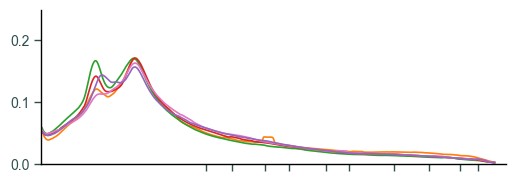

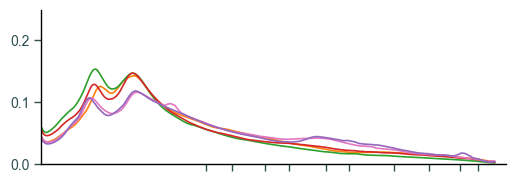

Total number of fragments in untreated ladder: 57640759771.23175
Total number of fragments in untreated CD4T: 31905364373.36344
Total number of fragments in untreated hESC-H9: 33661182544.13808
Total number of fragments in untreated HEK293T: 35339583538.12692
Total number of fragments in untreated RNH2-KO-T3-8: 35027939669.86203
Total number of fragments in untreated RNH2-KO-T3-17: 35361389133.48067
Total number of fragments in RNase HII treated ladder: 57640759771.23175
Total number of fragments in RNase HII treated CD4T: 36711592182.42858
Total number of fragments in RNase HII treated hESC-H9: 36361898208.346115
Total number of fragments in RNase HII treated HEK293T: 37528328578.814316
Total number of fragments in RNase HII treated RNH2-KO-T3-8: 43507573097.7914
Total number of fragments in RNase HII treated RNH2-KO-T3-17: 44313881429.202644


In [24]:

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'darkslategrey', 'ytick.color':'darkslategrey', 'figure.facecolor':'white'}):
    fig, ax = plt.subplots(figsize=(6,2))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
    ax.tick_params(width=1)
for k in ndata:
    ax.plot(moving_average(ndata[k],50), '-', color=palette[k], label=k, linewidth=1.2)
plt.xticks(X,fontsize=10, visible=False)
plt.xlim((0,pixels))
plt.yticks(np.arange(0, 0.25, 0.1), fontsize=10);plt.ylim(0,0.25)
plt.show()
fig.savefig('intensity_no_treatment_full.png',dpi=1000,bbox_inches='tight')

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'darkslategrey', 'ytick.color':'darkslategrey', 'figure.facecolor':'white'}):
    fig, ax = plt.subplots(figsize=(6,2))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
    ax.tick_params(width=1)
for k in adata:
    ax.plot(moving_average(adata[k],50), '-', color=palette[k], label=k, linewidth=1.2)
plt.xticks(X,fontsize=10, visible=False)
plt.xlim((0,pixels))
plt.yticks(np.arange(0, 0.25, 0.1), fontsize=10);plt.ylim(0,0.25)
plt.show()
fig.savefig('intensity_treatment_full.png',dpi=1000,bbox_inches='tight')

for k in nnorm_data:
    print("Total number of fragments in untreated "+k+": "+str(sum(nnorm_data[k])))

for k in anorm_data:
    print("Total number of fragments in RNase HII treated "+k+": "+str(sum(anorm_data[k])))


Untreated lane median for CD4T : 9832.345413785464
Untreated lane median for hESC-H9 : 10762.139515679632
Untreated lane median for HEK293T : 9563.908271419592
Untreated lane median for RNH2-KO-T3-8 : 9458.56984838948
Untreated lane median for RNH2-KO-T3-17 : 9285.54351370671
Treated lane median for CD4T : 8372.72857343804
Treated lane median for hESC-H9 : 9493.554845194347
Treated lane median for HEK293T : 8158.703404825475
Treated lane median for RNH2-KO-T3-8 : 6030.018492441489
Treated lane median for RNH2-KO-T3-17 : 5639.162977988763


C:\Users\deepa\AppData\Local\Temp\ipykernel_32392\4092900469.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "co" (-> color='c'). The keyword argument will take precedence.
  ax.plot(median_n.keys(),median_n.values(),'co', color='cornflowerblue',label=k, markersize=5.5)


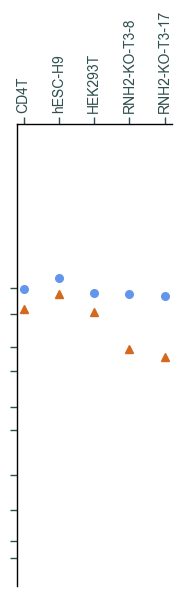

In [41]:


x=0;y=int(np.mean(ci_list)); data={}; pix=[*range(x, y, 1)] 
for k in nnorm_data:
    data[k]={'untreated':calc_stats(pix,nnorm_data[k][x:y]),'treated':calc_stats(pix,anorm_data[k][x:y])}
del data['ladder']

# Prepare data for plotting
categories = [*data[k]]; groups = [*data]; box_data = []
for group in groups:
    for category in categories:
        stats = data[group][category]; box_data.append([stats['min'], stats['q1'], stats['median'], stats['q3'], stats['max']]) #multiple each by -1 if needed

median_n={k:calc_stats(pix,nnorm_data[k][x:y])['median'] for k in nnorm_data};median_n.pop('ladder')
median_a={k:calc_stats(pix,anorm_data[k][x:y])['median'] for k in anorm_data};median_a.pop('ladder')
    
for k in median_n:
    print("Untreated lane median for " + str(k) + " : " + str(mws[int(np.round(median_n[k]))]) )
for k in median_a:
    print("Treated lane median for " + str(k) + " : " + str(mws[int(np.round(median_a[k]))]) )

for i in median_n:
    median_n[i]=median_n[i]*-1
for i in median_a:
    median_a[i]=median_a[i]*-1

# Plotting

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'darkslategrey', 'ytick.color':'darkslategrey', 'figure.facecolor':'white'}):
    fig, ax = plt.subplots(figsize=(2,6))
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
    ax.tick_params(width=1, labelsize=10)
ax.plot(median_n.keys(),median_n.values(),'co', color='cornflowerblue',label=k, markersize=5.5)
ax.plot(median_a.keys(),median_a.values(),"^", color='chocolate', label=k, markersize=5.5)
plt.xticks(rotation=90)
plt.ylim(-pixels,0)
plt.yticks(X*-1,fontsize=10, visible=False)
fig.savefig('fragmentsmedians.png',dpi=1000,bbox_inches='tight')
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False


# Getting medians